In [1]:
import torch as T
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

# ds_tr = datasets.MNIST('./', train=True, download=True)
ds_tr = datasets.MNIST('./', train=True)
ds_ts = datasets.MNIST('./', train=False)

print(len(ds_tr), len(ds_ts))

60000 10000



torch.Size([50]) torch.Size([50, 28, 28]) torch.Size([50])


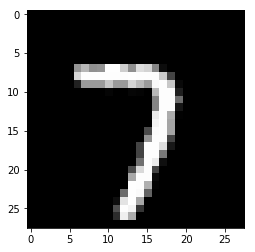

tensor(7)


In [2]:
import numpy as np
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
%matplotlib inline

class MNIST(Dataset):
    def __init__(self, ds):
        super().__init__()
        
        self.dat = []
        
        for img, lbl in tqdm(ds):
            img = np.asarray(img).astype(np.float32) / 255.0
            
            self.dat.append([img, lbl])
    
    def __len__(self):
        return len(self.dat)
    
    def __getitem__(self, idx):
        img, lbl = self.dat[idx]
        
        return idx, img, lbl

ld_tr = DataLoader(MNIST(ds_tr), batch_size=50, shuffle=True)
ld_ts = DataLoader(MNIST(ds_ts), batch_size=100)

for idx, img, lbl in ld_tr:
    print(idx.shape, img.shape, lbl.shape)
    
    plt.figure()
    plt.imshow(ds_tr[idx[0]][0])
    plt.show()
    plt.close()
    
    print(lbl[0])
    
    break

In [3]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc = nn.Sequential(nn.Linear(28**2, 10**2), nn.ReLU(), 
                                nn.Linear(10**2, 10**2), nn.ReLU(), 
                                nn.Linear(10**2, 10))
    
    def forward(self, img, is_tr=True):
        img = img.view((img.shape[0], -1))
        
        out = self.fc(img)
        
        if is_tr==True:
            sel = T.multinomial(nn.functional.softmax(out, dim=1), 1)
        else:
            sel = T.argmax(out, dim=1, keepdim=True)
        pb = T.gather(nn.functional.log_softmax(out, dim=1), 1, sel)
        
        sel = sel.view((-1))
        pb = pb.view((-1))
        
        return sel, pb

model = Model().cuda()
print(model)

sel, pb = model(img.cuda())
print(sel.shape, pb.shape)

sel, pb = model(img.cuda(), is_tr=False)
print(sel.shape, pb.shape)

Model(
  (fc): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)
torch.Size([50]) torch.Size([50])
torch.Size([50]) torch.Size([50])


In [4]:
EPOCHS = 20
LR = 0.0008

class LossPG(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.bl = 0
        self.bn = 0
    
    def forward(self, pb, rwd):
        ls = 0
        
        ls += -1.0 * pb * T.from_numpy(rwd-self.bl).cuda()
        ls = ls.sum() / ls.shape[0]
        
        rwd = np.average(rwd)
        self.bl = (self.bl*self.bn + rwd) / (self.bn+1)
        self.bn += 1
        
        return ls

loss_pg = LossPG().cuda()
optim = T.optim.Adam(model.parameters(), lr=LR)

In [5]:
for e in tqdm(range(EPOCHS)):
    ls_ep = 0
    
    with tqdm(ld_tr) as TQ:
        for _, img, lbl in TQ:
            sel, pb = model(img.cuda())
            
            rwd = (sel.detach().cpu().numpy() == lbl.numpy()).astype(np.float32)
            ls_bh = loss_pg(pb, rwd)
            
            optim.zero_grad()
            ls_bh.backward()
            optim.step()
            
            ls_bh = ls_bh.detach().cpu().numpy()
            ls_ep += ls_bh
            
            TQ.set_postfix(ls_bh='%.3f'%(ls_bh))
        
        ls_ep /= len(TQ)
        print('Ep %d: %.4f' % (e+1, ls_ep))
    
    acc_ep = 0
    with tqdm(ld_ts) as TQ:
        for _, img, lbl in TQ:
            sel, _ = model(img.cuda())
            
            sel = sel.detach().cpu().numpy()
            lbl = lbl.numpy()
            
            acc_bh = np.average(sel==lbl)
            acc_ep += acc_bh
            
            TQ.set_postfix(acc_bh='%.3f%%'%(acc_bh*100))
        
        acc_ep /= len(TQ)
        print('Test: %.4f%%'%(acc_ep*100))

Ep 1: -0.0663


Test: 73.5900%


Ep 2: -0.0429


Test: 82.8800%


Ep 3: -0.0305


Test: 83.2700%


Ep 4: -0.0267


Test: 85.1000%


Ep 5: -0.0267


Test: 93.7700%


Ep 6: -0.0200


Test: 94.7200%


Ep 7: -0.0164


Test: 94.5100%


Ep 8: -0.0162


Test: 95.5000%


Ep 9: -0.0144


Test: 95.1100%


Ep 10: -0.0133


Test: 95.0400%


Ep 11: -0.0105


Test: 95.4200%


Ep 12: -0.0114


Test: 96.4300%


Ep 13: -0.0107


Test: 95.6100%


Ep 14: -0.0090


Test: 95.5400%


Ep 15: -0.0089


Test: 96.0800%


Ep 16: -0.0078


Test: 96.5100%


Ep 17: -0.0084


Test: 95.8500%


Ep 18: -0.0074


Test: 96.5900%


Ep 19: -0.0074


Test: 96.6900%


Ep 20: -0.0072


Test: 96.7000%

